In [ ]:
!pip install wordcloud
!pip install zemberek-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141211 sha256=d668b00ddf5df98d52fa0abdade8acf17015d62dd0bcc905fff67666005b809f
  Stored in directory: /root/.cache/pip/wheels/a7/20/bd/e1477d664f22d99989fd28ee1a43d6633dddb5cb9e801350d5
Successfully built antlr4-python3-runtime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
import re
from nltk.corpus import stopwords
from textblob import Word
from textblob import TextBlob
from warnings import filterwarnings
import google.colab
from google.colab import drive
from google.colab import files

Uyarıların ignore edilmesi, satır ve sütun ayarları

In [ ]:
filterwarnings('ignore')

# DataFrame ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Veri Setlerinin Yüklenmesi

In [ ]:
training_data = pd.read_csv("/content/offenseval-tr-training-v1.tsv", sep='\t')
test_data = pd.read_csv("/content/offenseval-tr-testset-v1.tsv", sep='\t')
label_data = pd.read_csv("/content/offenseval-tr-labela-v1.tsv", sep='t')

Veri Setlerinin ilk 5'er sütunlarının yazdırılması

In [ ]:
print("Train Data Colonları: ", training_data.columns)
print("Labels Data Colonları: ", label_data.columns)
print("Test Data Colonları: ", test_data.columns)

print(training_data.head())


Train Data Columns:  Index(['id', 'tweet', 'subtask_a'], dtype='object')
Labels Data Columns:  Index(['41993,NOT'], dtype='object')
Test Data Columns:  Index(['id', 'tweet'], dtype='object')
      id                                              tweet subtask_a
0  20948  @USER en güzel uyuyan insan ödülü jeon jungkoo...       NOT
1  10134  @USER Mekanı cennet olsun, saygılar sayın avuk...       NOT
2  23457  Kızlar aranızda kas yığını beylere düşenler ol...       NOT
3  18401  Biraz ders çalışayım. Tembellik ve uyku düşman...       NOT
4  17525  @USER Trezeguet yerine El Sharawy daha iyi olm...       NOT


label_data nın sütun adlarının ayarlanması, id sütunlarının str olarak değiştirilmesi, label_data ve trainig_data üzerinden birleştirme

In [ ]:
label_data.columns = ['id_label']
label_data[['id', 'subtask_a']] = label_data['id_label'].str.split(',', expand=True)
label_data = label_data.drop(columns=['id_label'])

training_data['id'] = training_data['id'].astype(str)
label_data['id'] = label_data['id'].astype(str)

training_data = pd.merge(training_data, label_data, on='id', how='left')
training_data['subtask_a'] = training_data['subtask_a_x'].combine_first(training_data['subtask_a_y'])
training_data = training_data.drop(columns=['subtask_a_x', 'subtask_a_y'])

Lemmatize etmek için zemberek importu

In [ ]:
"""from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)"""

'from zemberek import (\n    TurkishSpellChecker,\n    TurkishSentenceNormalizer,\n    TurkishSentenceExtractor,\n    TurkishMorphology,\n    TurkishTokenizer\n)'

trainig_data nın **temizlenmesi ve ÖNİŞLEMESİ**

In [ ]:
training_data['tweet'] = training_data['tweet'].str.lower()  # Tüm metni küçük harfe çevirdik
training_data['tweet'] = training_data['tweet'].str.replace('[^\w\s]', '', regex=True)  # Noktalama işaretlerini kaldırdık
training_data['tweet'] = training_data['tweet'].str.replace('\d', '', regex=True)  # Sayıları kaldırdık
training_data['tweet'] = training_data['tweet'].str.replace('ttp\S+', '', regex=True)  #url kaldırdık
training_data['tweet'] = training_data['tweet'].str.replace('@\w+', '', regex=True)  # nahsetme kaldırdık
training_data['tweet'] = training_data['tweet'].str.replace('[^A-Za-zğüşöçİĞÜŞÖÇ ]+', '', regex=True)  # öze karakter kaldırdık
training_data['cleaned_tweet'] = training_data['tweet']

training_data veri seti ile** WORDCLOUD**

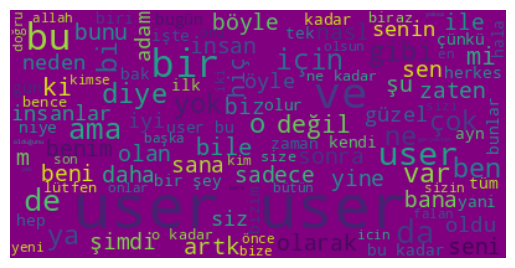

In [ ]:
tweets = " ".join(i for i in training_data.tweet)

wordcloud = WordCloud(max_font_size=50,
                      max_words=110,
                      background_color="purple").generate(tweets)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Zemberek kütüphanesi ile lemmatize işlemi yapmak istedim anca bu defa vectorizer hata veriyordu. Kodları silmek yerine yorum satırı haline getirdim


In [ ]:
"""morphology = TurkishMorphology.create_with_defaults()

def lemmatize(text):
    analysis = morphology.analyze_sentence(text)
    lemmas = [result.best_analysis().get_lemma() for result in analysis]
    return ' '.join(lemmas)

train_data['cleaned_tweet'] = train_data['cleaned_tweet'].apply(lambda x: lemmatize)"""


"morphology = TurkishMorphology.create_with_defaults()\n\ndef lemmatize(text):\n    analysis = morphology.analyze_sentence(text)\n    lemmas = [result.best_analysis().get_lemma() for result in analysis]\n    return ' '.join(lemmas)\n\ntrain_data['cleaned_tweet'] = train_data['cleaned_tweet'].apply(lambda x: lemmatize)"

In [ ]:
"""def lemmatize(text):
    analysis = zemberek.analyzeSentence(text)
    results = []
    for word_analysis in analysis:
        lemma = word_analysis.getLemmas()[0]
        results.append(lemma)
    return ' '.join(results)"""

"def lemmatize(text):\n    analysis = zemberek.analyzeSentence(text)\n    results = []\n    for word_analysis in analysis:\n        lemma = word_analysis.getLemmas()[0]\n        results.append(lemma)\n    return ' '.join(results)"

In [ ]:
#training_data['cleaned_tweet'] = training_data['cleaned_tweet'].apply(lambda x: lemmatize)

Vektörleştirdik. Bunu **TF-IDF** ile yaptık

In [ ]:

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(training_data['cleaned_tweet'])
y = training_data['subtask_a']


Veriyi eğitim ve test setine böldük. Logistic Regression ile eğittik.

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Model değerlendirme

In [ ]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         NOT       0.84      0.99      0.91      5003
         OFF       0.85      0.24      0.38      1253

    accuracy                           0.84      6256
   macro avg       0.84      0.62      0.64      6256
weighted avg       0.84      0.84      0.80      6256



test verisini temizledik

In [ ]:
test_data['tweet'] = test_data['tweet'].str.lower()  # Tüm metni küçük harfe çevirdik
test_data['tweet'] = test_data['tweet'].str.replace('[^\w\s]', '', regex=True)  # Noktalama işaretlerini kaldırdık
test_data['tweet'] = test_data['tweet'].str.replace('\d', '', regex=True)  # Sayıları kaldırdık
test_data['tweet'] = test_data['tweet'].str.replace('ttp\S+', '', regex=True)  #url kaldırdık
test_data['tweet'] = test_data['tweet'].str.replace('@\w+', '', regex=True)  # nahsetme kaldırdık
test_data['tweet'] = test_data['tweet'].str.replace('[^A-Za-zğüşöçİĞÜŞÖÇ ]+', '', regex=True)  # özel karakter kaldırdık
test_data['cleaned_tweet'] = test_data['tweet']

Test verilerini **ML modeline** soktuk ve tahminde bulundu.

In [ ]:
X_test = vectorizer.transform(test_data['cleaned_tweet'])

test_data['predicted_subtask_a'] = model.predict(X_test)


print(test_data[['tweet', 'predicted_subtask_a']])

                                                  tweet predicted_subtask_a
0           user sayn başkanm bu şekilde devam inşallah                 NOT
1       herkes gevşekliği kadar duyar kasyorhayat böyle                 NOT
2     olgun ilişkisi olan arkadaş size en güzel hediye                  NOT
3     user user burada atp tutacağna o kötü koşullar...                 NOT
4       user işte o onur dediğin sende yok sorun o işte                 NOT
...                                                 ...                 ...
3510          user çok iyi oyuncu serdardan çok çok iyi                 NOT
3511  user bu gün mnim bbşimin ad günüdü tbrik edirm...                 NOT
3512  bu gecelik bu kadar   yarn gün içerisinde göze...                 NOT
3513                   user okulu brak o zaman fbshshsb                 NOT
3514  ben bangtann albümünden sonra evde latata diye...                 NOT

[3515 rows x 2 columns]


Tahmin sonuçlarını cdv dosyası haline getirdik ve o dosyayı indirdik

In [ ]:
test_data[['id', 'predicted_subtask_a']].to_csv('test_results.csv', index=False)

google.colab.files.download('test_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>